In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


### defne the input points

In [2]:
## defining the dips position
G_1 = np.array([[0., 1.]])

G_1_x = 1
G_1_y = 1

G_1_tiled = np.tile(G_1,[2,1])

In [3]:
def squared_euclidean_distance(x_1,x_2):
    sqd = np.sqrt(np.reshape(np.sum(x_1**2,1),newshape =(x_1.shape[0],1))+\
    np.reshape(np.sum(x_2**2,1),newshape =(1,x_2.shape[0]))-\
    2*(x_1@x_2.T))
    return sqd

In [4]:
def cartesian_dist(x_1,x_2):
    return np.concatenate([
        np.tile(x_1[:,0] - np.reshape(x_2[:,0],[x_2.shape[0],1]),[1,2]),
        np.tile(x_1[:,1] - np.reshape(x_2[:,1],[x_2.shape[0],1]),[1,2])],axis = 0) 
h_u = cartesian_dist(G_1,G_1)
h_v = h_u.T

In [5]:
a = np.concatenate([np.ones([G_1.shape[0],G_1.shape[0]]),np.zeros([G_1.shape[0],G_1.shape[0]])],axis = 1)
b = np.concatenate([np.zeros([G_1.shape[0],G_1.shape[0]]),np.ones([G_1.shape[0],G_1.shape[0]])],axis = 1)

perpendicularity_matrix = np.concatenate([a,b],axis = 0)

In [6]:
dist_tiled = squared_euclidean_distance(G_1_tiled,G_1_tiled)

cubic covariance
$$
\begin{aligned}
&C(r)=
\left\{\begin{array}{ll}
C_{0}\left(1-7\left(\frac{r}{a}\right)^{2}+\frac{35}{4}\left(\frac{r}{a}\right)^{3}-\frac{7}{2}\left(\frac{r}{a}\right)^{5}+\frac{3}{4}\left(\frac{r}{a}\right)^{7}\right) & \text { for } 0 \leq r \leq a \\
0 & \text { for } r \geq a
\end{array}\right.
\end{aligned}
$$

In [7]:
a_T = 5
c_o_T = a_T**2/14/3

$$
\begin{array}{l}
\mathbf{C}_{\partial \mathbf{Z} / \partial u, \partial \mathbf{Z} / \partial u}=C_{Z}^{\prime}(r)\left(-\frac{h_{u}^{2}}{r^{3}}+\frac{1}{r}\right)-\frac{h_{u}}{r} C_{Z}^{\prime \prime} \frac{h_{u}}{r} \\
\quad=C_{Z}^{\prime}(r)\left(-\frac{h_{u}^{2}}{r^{3}}+\frac{1}{r}\right)+\frac{h_{u}^{2}}{r^{2}} C_{Z}^{\prime \prime}
\end{array} \tag{B9}
$$

$$
\begin{array}{l}
\mathbf{C}_{\partial \mathbf{Z} / \partial \mathbf{u}, \partial \mathbf{Z} / \partial \mathbf{v}}=C_{Z}^{\prime}(r)\left(-\frac{h_{u} h_{v}}{r^{3}}\right)+C_{Z}^{\prime \prime}(r) \frac{h_{u} h_{v}}{r^{2}} \\
\quad=\frac{h_{u} h_{v}}{r^{2}}\left(C_{Z}^{\prime \prime}(r)-\frac{C_{Z}^{\prime}(r)}{r}\right)
\end{array} \tag{B13}
$$



In [8]:
def cov_gradients(dist_tiled):
    
    condition1 = 0
    a = (h_u*h_v)
    b = dist_tiled**2

    t1 =  np.divide(a, b, out=np.zeros_like(a), where=b!=0)
    t2 = -c_o_T*((-14/a_T**2)+
                 105/4*dist_tiled/a_T**3 -
                 35/2 * dist_tiled**3 / a_T **5 +
                 21 /4 * dist_tiled**5/a_T**7)+\
         c_o_T * 7 * (9 * dist_tiled ** 5 -
                      20 * a_T ** 2 * dist_tiled ** 3 +
                      15 * a_T ** 4 * dist_tiled -
                      4 * a_T ** 5) / (2 * a_T ** 7)

    # when we do the covariance of Gx with Gx, Gy with Gy and so on, quation B9 in Gempy paper
    t3 = perpendicularity_matrix * \
         c_o_T * ((-14 / a_T ** 2) + 105 / 4 * dist_tiled / a_T ** 3 -
                   35 / 2 * dist_tiled ** 3 / a_T ** 5 +
                   21 / 4 * dist_tiled ** 5 / a_T ** 7)
    t4 = 1/3*np.eye(dist_tiled.shape[0])

    condition2 = t1 * t2 - t3 + t4

    C_G = np.where(dist_tiled==0, condition1, condition2) ## adding nugget effect
    return C_G


In [9]:
dist_tiled = dist_tiled + np.eye(dist_tiled.shape[0])

C_G = cov_gradients(dist_tiled)

C_G

array([[0.54496, 0.     ],
       [0.     , 0.54496]])

### covariance of interface points

In [10]:
layer1 = np.array([[0,0],[2,0]])
layer2 = np.array([[0,2],[2,2]])

layer1 = np.array([[0,0],[2,0],[3,0],[4,0]])
layer2 = np.array([[0,2],[2,2],[3,3]])

number_of_layer = 2

In [11]:
number_of_points_per_surface = np.array([layer1.shape[0],layer2.shape[0]])

In [12]:
def set_rest_ref_matrix(number_of_points_per_surface):
    ref_layer_points = np.repeat(np.stack([layer1[-1],layer2[-1]],axis = 0),repeats=number_of_points_per_surface-1,axis = 0)
    rest_layer_points = np.concatenate([layer1[0:-1],layer2[0:-1]],axis = 0)
    return ref_layer_points,rest_layer_points

In [13]:
ref_layer_points,rest_layer_points = set_rest_ref_matrix(number_of_points_per_surface)

In [14]:
sed_rest_rest = squared_euclidean_distance(rest_layer_points,rest_layer_points)
sed_ref_rest = squared_euclidean_distance(ref_layer_points,rest_layer_points)
sed_rest_ref = squared_euclidean_distance(rest_layer_points,ref_layer_points)
sed_ref_ref = squared_euclidean_distance(ref_layer_points,ref_layer_points)

In [15]:
def cov_interface(ref_layer_points,rest_layer_points):
    sed_rest_rest = squared_euclidean_distance(rest_layer_points,rest_layer_points)
    sed_ref_rest = squared_euclidean_distance(ref_layer_points,rest_layer_points)
    sed_rest_ref = squared_euclidean_distance(rest_layer_points,ref_layer_points)
    sed_ref_ref = squared_euclidean_distance(ref_layer_points,ref_layer_points)
    
    C_I = c_o_T*((1 - 7 * (sed_rest_rest / a_T) ** 2 +\
                 35 / 4 * (sed_rest_rest / a_T) ** 3 -\
                 7 / 2 * (sed_rest_rest / a_T) ** 5 +\
                 3 / 4 * (sed_rest_rest / a_T) ** 7) -\
                 (1 - 7 * (sed_ref_rest / a_T) ** 2 +\
                  35 / 4 * (sed_ref_rest / a_T) ** 3 -\
                  7 / 2 * (sed_ref_rest / a_T) ** 5 +\
                  3 / 4 * (sed_ref_rest / a_T) ** 7) -\
                 (1 - 7 * (sed_rest_ref / a_T) ** 2 +\
                  35 / 4 * (sed_rest_ref / a_T) ** 3 -\
                  7 / 2 * (sed_rest_ref / a_T) ** 5 +\
                  3 / 4 * (sed_rest_ref / a_T) ** 7) +\
                 (1 - 7 * (sed_ref_ref / a_T) ** 2 +\
                  35 / 4 * (sed_ref_ref / a_T) ** 3 -\
                  7 / 2 * (sed_ref_ref / a_T) ** 5 +\
                  3 / 4 * (sed_ref_ref / a_T) ** 7))
    
    return C_I

In [16]:
C_I = cov_interface(ref_layer_points,rest_layer_points)

In [17]:
C_I

array([[1.17808762, 0.58904381, 0.1902019 , 0.29198873, 0.05124151],
       [0.58904381, 0.70787048, 0.35393524, 0.09175378, 0.14899344],
       [0.1902019 , 0.35393524, 0.2513219 , 0.00276594, 0.08247576],
       [0.29198873, 0.09175378, 0.00276594, 1.08359866, 0.40705288],
       [0.05124151, 0.14899344, 0.08247576, 0.40705288, 0.43837758]])

### Covariance of interface points and gradients

In [18]:
sed_dips_rest = squared_euclidean_distance(G_1_tiled,rest_layer_points)
sed_dips_ref = squared_euclidean_distance(G_1_tiled,ref_layer_points)

In [19]:
## Cartesian distance between dips and interface points

def cartesian_dist_no_tile(x_1,x_2):
    return np.concatenate([
        np.transpose((x_1[:,0] - np.reshape(x_2[:,0],[x_2.shape[0],1]))),
        np.transpose((x_1[:,1] - np.reshape(x_2[:,1],[x_2.shape[0],1])))],axis = 0) 

hu_rest = cartesian_dist_no_tile(G_1,rest_layer_points)
hu_ref = cartesian_dist_no_tile(G_1,ref_layer_points)

In [20]:
def cov_interface_gradients(hu_rest,hu_ref):
    C_GI = (hu_rest*(- c_o_T * ((-14 / a_T ** 2) + 105 / 4 * sed_dips_rest / a_T ** 3 -
                                  35 / 2 * sed_dips_rest ** 3 / a_T ** 5 +
                                  21 / 4 * sed_dips_rest ** 5 / a_T ** 7))-\
    hu_ref*(-c_o_T * ((-14 / a_T ** 2) + 105 / 4 * sed_dips_ref / a_T ** 3 -
                                  35 / 2 * sed_dips_ref ** 3 / a_T ** 5 +
                                  21 / 4 * sed_dips_ref ** 5 / a_T ** 7)))
    return C_GI

In [21]:
C_GI = cov_interface_gradients(hu_rest,hu_ref)
C_IG = C_GI.T

### Kriging Matrix

In [22]:
K = np.concatenate([np.concatenate([C_G,C_GI],axis = 1),
np.concatenate([C_IG,C_I],axis = 1)],axis = 0)


In [23]:
import pandas as pd
pd.DataFrame(K)

,0,1,2,3,4,5,6
0,0.544960,0.000000,0.015699,-0.162014,-0.076728,0.043519,-0.134194
1,0.000000,0.544960,0.207702,0.084932,0.026884,-0.182614,-0.059844
2,0.015699,0.207702,1.178088,0.589044,0.190202,0.291989,0.051242
3,-0.162014,0.084932,0.589044,0.707870,0.353935,0.091754,0.148993
4,-0.076728,0.026884,0.190202,0.353935,0.251322,0.002766,0.082476
5,0.043519,-0.182614,0.291989,0.091754,0.002766,1.083599,0.407053
6,-0.134194,-0.059844,0.051242,0.148993,0.082476,0.407053,0.438378


In [24]:
b = np.concatenate([[G_1_x,G_1_y],np.zeros(K.shape[0]-G_1.shape[0]*2)],axis = 0)
b = np.reshape(b,newshape = [b.shape[0],1])
b

array([[1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [25]:
w = np.linalg.solve(K,b)
w

array([[ 2.32162776],
       [ 2.20952965],
       [-1.13604187],
       [ 1.6563299 ],
       [-1.20037611],
       [ 0.22195066],
       [ 0.60190314]])

### Interpolation without Universal term

In [26]:
## create grid

xx = np.arange(-.5,4.5,0.1)
yy = np.arange(-.5,4.5,0.1)
XX,YY = np.meshgrid(xx,yy)
X = (np.reshape(XX,[-1])).T
Y = (np.reshape(YY,[-1])).T

grid = np.stack([X,Y],axis = 1)

In [27]:
hu_Simpoints = cartesian_dist_no_tile(G_1,grid)

In [28]:
sed_dips_SimPoint = squared_euclidean_distance(G_1_tiled,grid)

In [29]:
# gradient contribution
sigma_0_grad = w[:G_1.shape[0]*2] * (-hu_Simpoints*(- c_o_T * ((-14 / a_T ** 2) + 105 / 4 * sed_dips_SimPoint / a_T ** 3 -
                               35 / 2 * sed_dips_SimPoint ** 3 / a_T ** 5 +
                               21 / 4 * sed_dips_SimPoint ** 5 / a_T ** 7)))

sigma_0_grad = np.sum(sigma_0_grad,axis=0)

In [30]:
sed_rest_SimPoint = squared_euclidean_distance(rest_layer_points,grid)
sed_ref_SimPoint = squared_euclidean_distance(ref_layer_points,grid)

In [31]:
# surface point contribution
sigma_0_interf = -w[G_1.shape[0]*2:]*(c_o_T  * ((1 - 7 * (sed_rest_SimPoint / a_T) ** 2 +
             35 / 4 * (sed_rest_SimPoint / a_T) ** 3 -
             7 / 2 * (sed_rest_SimPoint / a_T) ** 5 +
             3 / 4 * (sed_rest_SimPoint / a_T) ** 7) -
             (1 - 7 * (sed_ref_SimPoint / a_T) ** 2 +
              35 / 4 * (sed_ref_SimPoint / a_T) ** 3 -
              7 / 2 * (sed_ref_SimPoint / a_T) ** 5 +
              3 / 4 * (sed_ref_SimPoint / a_T) ** 7)))
sigma_0_interf = np.sum(sigma_0_interf,axis = 0)

In [32]:
interpolate_result = sigma_0_grad+sigma_0_interf
intp = np.reshape(interpolate_result,[50,50])

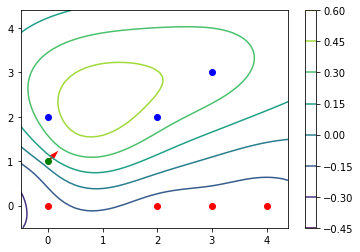

In [33]:
plt.contour(XX,YY,intp)
plt.colorbar()
plt.plot(layer1[:,0], layer1[:,1], 'ro')
plt.plot(layer2[:,0], layer2[:,1], 'bo')

plt.plot(G_1[0,0], G_1[0,1], 'go')
plt.quiver([G_1[0,0]],[G_1[0,1]],G_1_x,G_1_y,color='r')

## add drift term

In [34]:
U = np.concatenate([np.eye(number_of_layer),
np.stack([ref_layer_points[:,0] - rest_layer_points[:,0],
ref_layer_points[:,1] - rest_layer_points[:,1]])],axis = 1)

U_T = U.T


In [35]:
### new K matrix

zero_matrix = np.zeros([2,2])

K_U = np.concatenate([np.concatenate([K,U_T],axis = 1),np.concatenate([U,zero_matrix],axis = 1)],axis = 0)

In [36]:
pd.DataFrame(K_U)

,0,1,2,3,4,5,6,7,8
0,0.544960,0.000000,0.015699,-0.162014,-0.076728,0.043519,-0.134194,1.0,0.0
1,0.000000,0.544960,0.207702,0.084932,0.026884,-0.182614,-0.059844,0.0,1.0
2,0.015699,0.207702,1.178088,0.589044,0.190202,0.291989,0.051242,4.0,0.0
3,-0.162014,0.084932,0.589044,0.707870,0.353935,0.091754,0.148993,2.0,0.0
4,-0.076728,0.026884,0.190202,0.353935,0.251322,0.002766,0.082476,1.0,0.0
5,0.043519,-0.182614,0.291989,0.091754,0.002766,1.083599,0.407053,3.0,1.0
6,-0.134194,-0.059844,0.051242,0.148993,0.082476,0.407053,0.438378,1.0,1.0
7,1.000000,0.000000,4.000000,2.000000,1.000000,3.000000,1.000000,0.0,0.0
8,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,0.0


In [37]:
### universal contribution
sigma_0_1st_drift = np.sum(grid * (w[-2:]).T,axis = 1)
sigma_0_1st_drift

array([-0.4119269 , -0.38973183, -0.36753677, ...,  3.58056659,
        3.60276166,  3.62495672])

In [38]:
# rhs b-vector
b = np.concatenate([[G_1_x,G_1_y],np.zeros(K_U.shape[0]-G_1.shape[0]*2)],axis = 0)
b = np.reshape(b,newshape = [b.shape[0],1])

In [39]:
w = np.linalg.solve(K_U,b)
w

array([[ 2.05253201],
       [ 0.82112579],
       [-0.84916713],
       [ 1.78330264],
       [-1.13934764],
       [-0.13099767],
       [-0.69012811],
       [ 0.00937436],
       [ 0.54284228]])

In [40]:
# gradient contribution
sigma_0_grad = w[:G_1.shape[0]*2] * (-hu_Simpoints*(- c_o_T * ((-14 / a_T ** 2) + 105 / 4 * sed_dips_SimPoint / a_T ** 3 -
                               35 / 2 * sed_dips_SimPoint ** 3 / a_T ** 5 +
                               21 / 4 * sed_dips_SimPoint ** 5 / a_T ** 7)))

sigma_0_grad = np.sum(sigma_0_grad,axis=0)

# surface point contribution
sigma_0_interf = -w[G_1.shape[0]*2:-2]*(c_o_T  * ((1 - 7 * (sed_rest_SimPoint / a_T) ** 2 +
             35 / 4 * (sed_rest_SimPoint / a_T) ** 3 -
             7 / 2 * (sed_rest_SimPoint / a_T) ** 5 +
             3 / 4 * (sed_rest_SimPoint / a_T) ** 7) -
             (1 - 7 * (sed_ref_SimPoint / a_T) ** 2 +
              35 / 4 * (sed_ref_SimPoint / a_T) ** 3 -
              7 / 2 * (sed_ref_SimPoint / a_T) ** 5 +
              3 / 4 * (sed_ref_SimPoint / a_T) ** 7)))
sigma_0_interf = np.sum(sigma_0_interf,axis = 0)


In [41]:
sigma_0_1st_drift = np.sum(grid * (w[-2:]).T,axis = 1)
sigma_0_1st_drift

array([-0.27610832, -0.27517089, -0.27423345, ...,  2.42787838,
        2.42881582,  2.42975325])

In [42]:
interpolate_result = sigma_0_grad+sigma_0_interf+sigma_0_1st_drift

intp = np.reshape(interpolate_result,[50,50]) # reshape the result to matrix shape

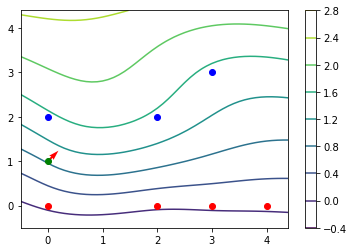

In [43]:
plt.contour(XX,YY,intp)
plt.colorbar()
plt.plot(layer1[:,0], layer1[:,1], 'ro')
plt.plot(layer2[:,0], layer2[:,1], 'bo')

plt.plot(G_1[0,0], G_1[0,1], 'go')
plt.quiver([G_1[0,0]],[G_1[0,1]],G_1_x,G_1_y,color='r')

## add 2nd order drift term 

In [44]:
a1 = np.eye(number_of_layer)

a2 = np.stack([ref_layer_points[:,0] - rest_layer_points[:,0],ref_layer_points[:,1] - rest_layer_points[:,1]])

a3 = np.stack([[0*2,0],[0,1*2],[0,1]])

a4 = np.stack([ref_layer_points[:,0]*ref_layer_points[:,0].T - rest_layer_points[:,0]*rest_layer_points[:,0].T , ref_layer_points[:,1]*ref_layer_points[:,1].T - rest_layer_points[:,1]*rest_layer_points[:,1].T , ref_layer_points[:,0]*ref_layer_points[:,1] - rest_layer_points[:,0]*rest_layer_points[:,1]])

U_2nd = np.concatenate([np.concatenate([a1,a2],axis=1),np.concatenate([a3,a4],axis=1)], axis=0)

U_2nd_T = U_2nd.T

In [45]:
zero_matrix = np.zeros([5,5])

K_U_2nd = np.concatenate([np.concatenate([K,U_2nd_T],axis = 1),np.concatenate([U_2nd,zero_matrix],axis = 1)],axis = 0)

In [46]:
pd.DataFrame(K_U_2nd)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.544960,0.000000,0.015699,-0.162014,-0.076728,0.043519,-0.134194,1.0,0.0,0.0,0.0,0.0
1,0.000000,0.544960,0.207702,0.084932,0.026884,-0.182614,-0.059844,0.0,1.0,0.0,2.0,1.0
2,0.015699,0.207702,1.178088,0.589044,0.190202,0.291989,0.051242,4.0,0.0,16.0,0.0,0.0
3,-0.162014,0.084932,0.589044,0.707870,0.353935,0.091754,0.148993,2.0,0.0,12.0,0.0,0.0
4,-0.076728,0.026884,0.190202,0.353935,0.251322,0.002766,0.082476,1.0,0.0,7.0,0.0,0.0
5,0.043519,-0.182614,0.291989,0.091754,0.002766,1.083599,0.407053,3.0,1.0,9.0,5.0,9.0
6,-0.134194,-0.059844,0.051242,0.148993,0.082476,0.407053,0.438378,1.0,1.0,5.0,5.0,5.0
7,1.000000,0.000000,4.000000,2.000000,1.000000,3.000000,1.000000,0.0,0.0,0.0,0.0,0.0
8,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0
9,0.000000,0.000000,16.000000,12.000000,7.000000,9.000000,5.000000,0.0,0.0,0.0,0.0,0.0


In [47]:
b_2nd = np.concatenate([[G_1_x,G_1_y],np.zeros(K_U_2nd.shape[0]-G_1.shape[0]*2)],axis = 0)

b_2nd = np.reshape(b_2nd,newshape = [b_2nd.shape[0],1])

w_2nd = np.linalg.solve(K_U_2nd,b_2nd)

In [48]:
# gradient contribution
sigma_0_grad = w_2nd[:G_1.shape[0]*2] * (-hu_Simpoints*(- c_o_T * ((-14 / a_T ** 2) + 105 / 4 * sed_dips_SimPoint / a_T ** 3                -35 / 2 * sed_dips_SimPoint ** 3 / a_T ** 5 + 21 / 4 * sed_dips_SimPoint ** 5 / a_T ** 7)))

sigma_0_grad = np.sum(sigma_0_grad,axis=0)
# surface point contribution
sigma_0_interf = -w_2nd[G_1.shape[0]*2:-5]*(c_o_T  * ((1 - 7 * (sed_rest_SimPoint / a_T) ** 2 +
             35 / 4 * (sed_rest_SimPoint / a_T) ** 3 -
             7 / 2 * (sed_rest_SimPoint / a_T) ** 5 +
             3 / 4 * (sed_rest_SimPoint / a_T) ** 7) -
             (1 - 7 * (sed_ref_SimPoint / a_T) ** 2 +
              35 / 4 * (sed_ref_SimPoint / a_T) ** 3 -
              7 / 2 * (sed_ref_SimPoint / a_T) ** 5 +
              3 / 4 * (sed_ref_SimPoint / a_T) ** 7)))
sigma_0_interf = np.sum(sigma_0_interf,axis = 0)

In [49]:
# 2nd order drift contribution
sigma_0_2nd_drift_1 = np.sum(grid* (w_2nd[-5:-3]).T,axis = 1)

grid_squr = grid*grid

sigma_0_2nd_drift_2 = np.sum(grid_squr* (w_2nd[-3:-1]).T,axis = 1)

grid_xy = grid[:,0]*grid[:,1]


sigma_0_2nd_drift_3 = grid_xy * w_2nd[-1]

sigma_0_2nd_drift = sigma_0_2nd_drift_1 + sigma_0_2nd_drift_2 + sigma_0_2nd_drift_3

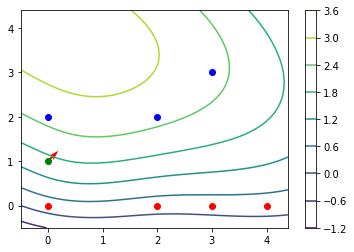

In [50]:
interpolate_result = sigma_0_grad+sigma_0_interf+sigma_0_2nd_drift

intp = np.reshape(interpolate_result,[50,50]) # reshape the result to matrix shape

plt.contour(XX,YY,intp)
plt.colorbar()
plt.plot(layer1[:,0], layer1[:,1], 'ro')
plt.plot(layer2[:,0], layer2[:,1], 'bo')

plt.plot(G_1[0,0], G_1[0,1], 'go')

plt.quiver([G_1[0,0]],[G_1[0,1]],G_1_x,G_1_y,color='r')